# Modelo de Clasificación de Señas ASL

Este notebook implementa un modelo de clasificación de señas del alfabeto americano (ASL) utilizando técnicas de deep learning con TensorFlow y Keras.

## Características principales:
- **Transfer Learning**: Uso de MobileNetV2 como modelo base
- **Data Augmentation**: Técnicas para enriquecer el conjunto de datos
- **Balanceo de clases**: Uso de pesos de clase para compensar el desbalance
- **Regularización**: Técnicas para evitar el sobreajuste
- **Visualización y métricas**: Análisis detallado del rendimiento del modelo

Primero, se descarga y descomprime el dataset con imágenes de señas del alfabeto ASL desde Google Drive.


In [ ]:
# Instalación de dependencias necesarias
!pip install -q gdown matplotlib seaborn scikit-learn tensorflow tensorflow-addons

# Descarga del dataset desde Google Drive
print("Descargando el dataset desde Google Drive...")
!gdown --id 1rWGLHRAUvbniGP9Z6uydGqVFAw3ffKU5 --output archive.zip

# Descompresión del archivo
print("Descomprimiendo el archivo...")
!unzip -q archive.zip

print("Dataset descargado y descomprimido correctamente.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
Descargando el dataset desde Google Drive...
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1rWGLHRAUvbniGP9Z6uydGqVFAw3ffKU5
From (redirected): https://drive.google.com/uc?id=1rWGLHRAUvbniGP9Z6uydGqVFAw3ffKU5&confirm=t&uuid=75c96dc6-eefa-4263-ab3d-b661d139abd2
To: /content/archive.zip
100% 1.10G/1.10G [00:09<00:00, 122MB/s]
Descomprimiendo el archivo...
Dataset descargado y descomprimido correctamente.


# Análisis de distribución de clases

Verificamos la cantidad de imágenes por clase para entender la distribución del dataset. Esto nos ayudará a identificar posibles desbalances que debamos corregir durante el entrenamiento.

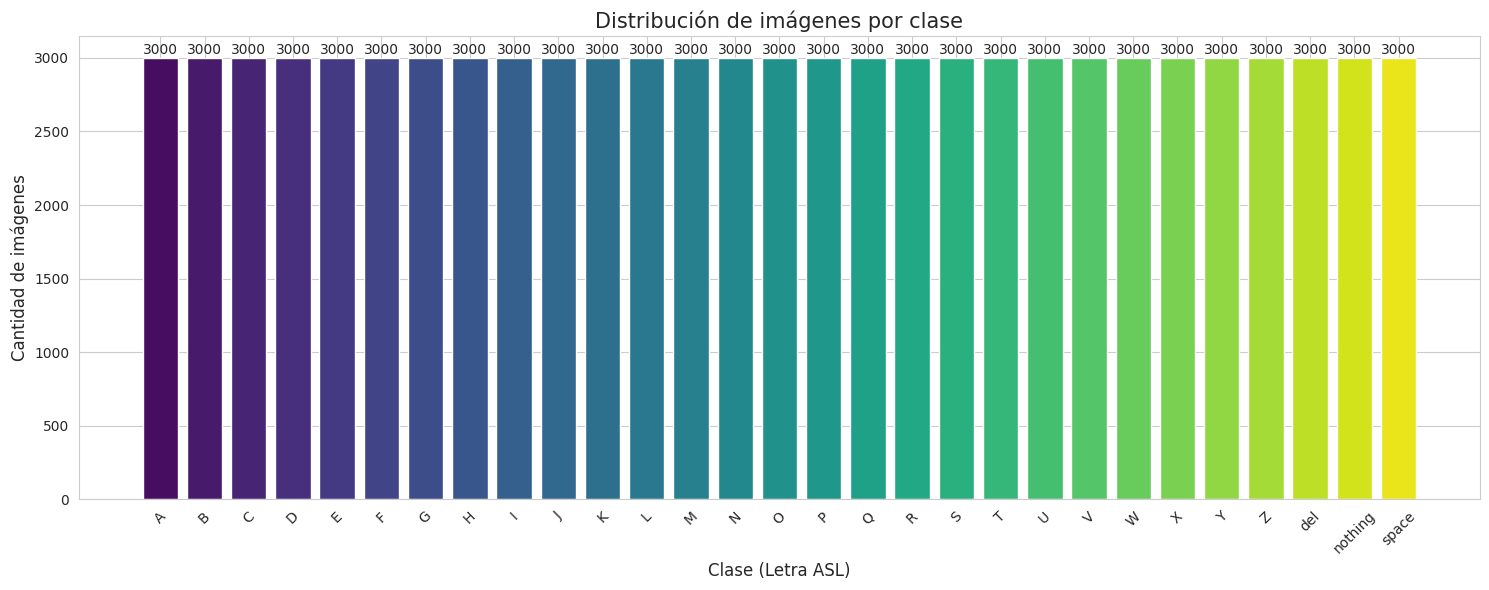

Total de imágenes: 87000
Promedio de imágenes por clase: 3000.00
Mínimo de imágenes en una clase: 3000
Máximo de imágenes en una clase: 3000
Desviación estándar: 0.00
Ratio máx/mín: 1.00

Pesos más altos (clases menos representadas):
Clase U: 1.0000
Clase I: 1.0000
Clase R: 1.0000
Clase W: 1.0000
Clase del: 1.0000


In [ ]:
import os
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Ajustar la ruta según la estructura después de descomprimir
directorio_base = 'asl_alphabet_train/asl_alphabet_train'
if not os.path.exists(directorio_base):
    directorio_base = 'asl_alphabet_train'  # Alternativa si la estructura es diferente

# Contar imágenes por clase
conteo = {}
for subcarpeta in os.listdir(directorio_base):
    ruta_subcarpeta = os.path.join(directorio_base, subcarpeta)
    if os.path.isdir(ruta_subcarpeta):
        num_imagenes = len(os.listdir(ruta_subcarpeta))
        conteo[subcarpeta] = num_imagenes

# Ordenar por nombre de clase
clases_ordenadas = sorted(conteo.keys())
cantidades = [conteo[clase] for clase in clases_ordenadas]

# Configurar estilo de visualización
plt.figure(figsize=(15, 6))
sns.set_style("whitegrid")
bars = plt.bar(clases_ordenadas, cantidades, color=sns.color_palette("viridis", len(clases_ordenadas)))
plt.title('Distribución de imágenes por clase', fontsize=15)
plt.xlabel('Clase (Letra ASL)', fontsize=12)
plt.ylabel('Cantidad de imágenes', fontsize=12)
plt.xticks(rotation=45)

# Añadir etiquetas de cantidad
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{height}', ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.show()

# Estadísticas del balance de clases
total_imagenes = sum(cantidades)
promedio = np.mean(cantidades)
minimo = np.min(cantidades)
maximo = np.max(cantidades)
desviacion = np.std(cantidades)

print(f"Total de imágenes: {total_imagenes}")
print(f"Promedio de imágenes por clase: {promedio:.2f}")
print(f"Mínimo de imágenes en una clase: {minimo}")
print(f"Máximo de imágenes en una clase: {maximo}")
print(f"Desviación estándar: {desviacion:.2f}")
print(f"Ratio máx/mín: {maximo/minimo:.2f}")

# Calcular pesos de clase para balanceo
pesos_clases = {clase: total_imagenes/(len(conteo) * cantidad) for clase, cantidad in conteo.items()}

# Mostrar los 5 pesos más altos (clases menos representadas)
print("\nPesos más altos (clases menos representadas):")
for clase, peso in sorted(pesos_clases.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"Clase {clase}: {peso:.4f}")

# Guardar pesos para usar en el entrenamiento
class_weights = {i: pesos_clases[clase] for i, clase in enumerate(sorted(conteo.keys()))}

# Arquitectura del modelo

Utilizamos un enfoque de Transfer Learning con MobileNetV2 como modelo base, que es eficiente y adecuado para tareas de visión por computadora en dispositivos con recursos limitados.

En esta implementación mejorada:
1. Usamos regularización (Dropout) para prevenir sobreajuste
2. Aplicamos fine-tuning selectivo (congelamos capas iniciales)
3. Añadimos BatchNormalization para estabilizar el entrenamiento
4. Configuramos el optimizador con learning rate reducido
5. Implementamos una arquitectura con capas densas adicionales

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Parámetros del modelo
IMG_SIZE = 224  # Tamaño estándar para MobileNetV2
NUM_CLASSES = 29  # A-Z + Nothing + Delete + Space
BATCH_SIZE = 32

print(f"TensorFlow versión: {tf.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")

# Crear el modelo base usando MobileNetV2 preentrenado en ImageNet
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Congelar las primeras capas del modelo base para conservar características generales
# Esto implementa un enfoque de fine-tuning más selectivo
for layer in base_model.layers[:-20]:
    layer.trainable = False

print(f"Total de capas en el modelo base: {len(base_model.layers)}")
print(f"Capas entrenables: {sum(1 for layer in base_model.layers if layer.trainable)}")

# Construir la arquitectura completa con regularización mejorada
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)  # Mayor dropout para reducir sobreajuste

# Primera capa densa con regularización L2
x = Dense(
    256,
    activation='relu',
    kernel_regularizer=l2(0.001)
)(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Segunda capa densa con regularización L2
x = Dense(
    128,
    activation='relu',
    kernel_regularizer=l2(0.001)
)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Capa de salida con softmax para clasificación multiclase
outputs = Dense(
    NUM_CLASSES,
    activation='softmax',
    kernel_regularizer=l2(0.001)
)(x)

# Ensamblar el modelo final
model = Model(inputs=inputs, outputs=outputs)

# Compilar con métricas adicionales para mejor seguimiento
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3_accuracy')
    ]
)

# Mostrar resumen de la arquitectura
model.summary()

# Guardar el modelo inicial
model.save("modelo_senas_inicial.keras")


KeyboardInterrupt: 

## Se crea imagen del modelo para visualizar su composición.


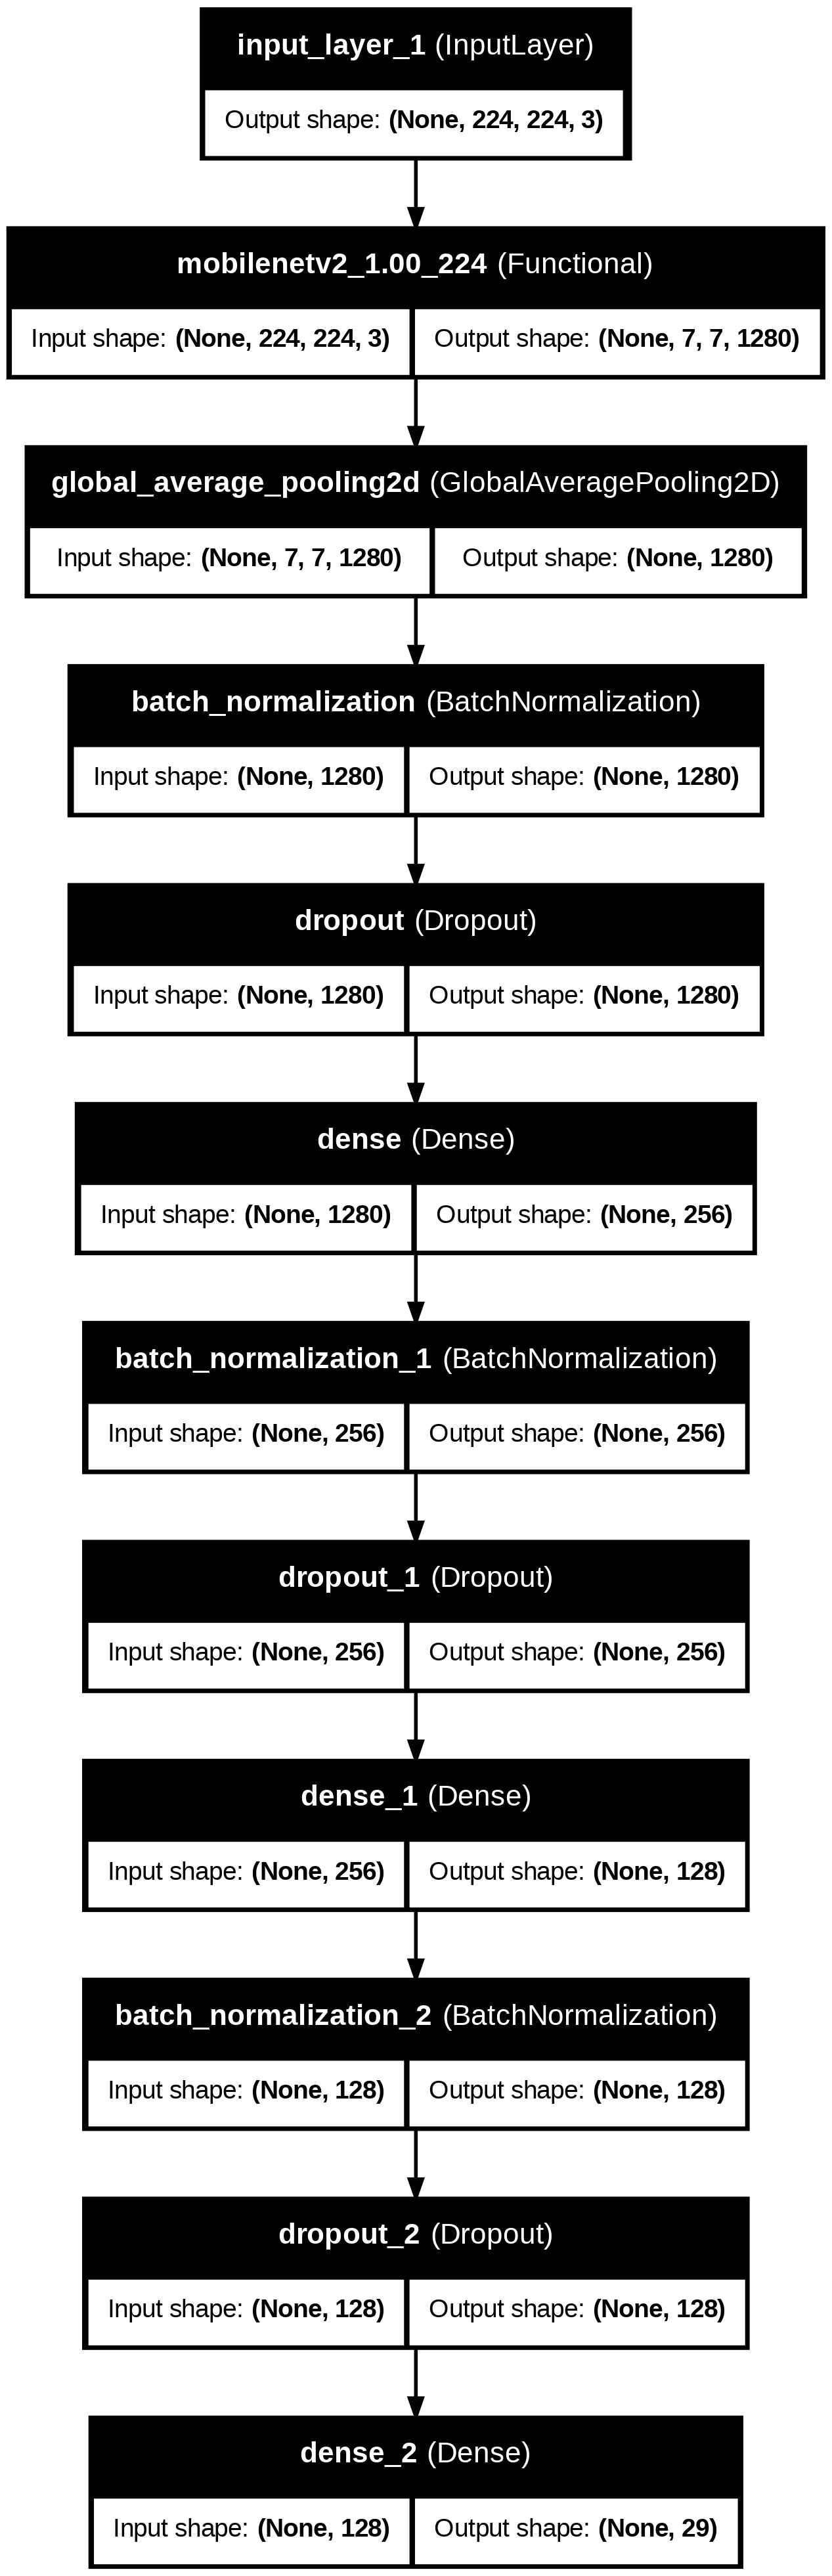

In [ ]:
!pip install pydot
from tensorflow.keras.utils import plot_model

plot_model(model, to_file="modelo.png", show_shapes=True, show_layer_names=True)

# Cargar el modelo desde el drive previamente guardado

In [ ]:
# Cargar el entrenado desde el drive
from tensorflow.keras.models import load_model
from google.colab import drive
import os

# Permite el acceso a grandes cantidades de datos
drive.mount('/content/drive')

# Verifica que el directorio exista
print(f"Checking if directory exists: {os.path.exists('/content/drive/MyDrive/models')}")

# Verifica la lista de archivos y lista el contenido
print(f"Files in directory /content/drive/MyDrive/models:")
!ls -l /content/drive/MyDrive/models/

modelo_cargado = load_model('/content/drive/MyDrive/models/modelo_senas_best(47).keras')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Checking if directory exists: True
Files in directory /content/drive/MyDrive/models:
total 121590
drwx------ 3 root root     4096 Jul 19 01:15  Logs_entrenamiento
-rw------- 1 root root 23739852 Jul  4 13:25 'modelo_senas_best(28).keras'
-rw------- 1 root root 23739852 Jul 19 00:23 'modelo_senas_best(47).keras'
-rw------- 1 root root 23745846 Jun 21 03:16  modelo_senas_best.keras
-rw------- 1 root root 23739852 Jul  8 20:01  modelo_senas_final.keras
-rw------- 1 root root 29537901 May 27 04:52  modelo_senas.keras


# Preparación de datos con Data Augmentation

Aplicamos técnicas de preparación de datos avanzadas:

1. **Data Augmentation**: Para aumentar artificialmente el tamaño del dataset y mejorar la generalización
   - Rotación aleatoria*
   - Zoom aleatorio*
   - Desplazamientos horizontales y verticales*
   - Volteo horizontal*
   - Brillo y contraste aleatorio*

2. **Train/Validation/Test Split**: División 70% entrenamiento, 20% validación, 10% test

3. **Normalización**: Escalado de valores de píxeles a [0,1]

4. **Balanceo de clases**: Utilizamos pesos calculados anteriormente para compensar el desbalance


In [ ]:
import os
import cv2
import numpy as np
!pip install mediapipe
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# === CONFIGURACIÓN ===
IMG_SIZE = 224
BATCH_SIZE = 32
DATASET_PATH = 'asl_alphabet_train/asl_alphabet_train'  # Ajusta si es necesario

# === MEDIAPIPE CONFIG ===
mp_hands = mp.solutions.hands

# === GENERADOR PERSONALIZADO ===
class HandDatasetGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size, img_size, augmenter, shuffle=True):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.augmenter = augmenter
        self.shuffle = shuffle
        self.indices = np.arange(len(self.file_paths))
        self.hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []
        batch_labels = []

        for i in batch_indices:
            img = cv2.imread(self.file_paths[i])
            if img is None:
                continue

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            results = self.hands.process(img_rgb)

            if results.multi_hand_landmarks:
                h, w, _ = img.shape
                x_min, x_max = w, 0
                y_min, y_max = h, 0

                for landmark in results.multi_hand_landmarks[0].landmark:
                    x, y = int(landmark.x * w), int(landmark.y * h)
                    x_min = min(x_min, x)
                    x_max = max(x_max, x)
                    y_min = min(y_min, y)
                    y_max = max(y_max, y)

                margin = 20
                x_min = max(0, x_min - margin)
                x_max = min(w, x_max + margin)
                y_min = max(0, y_min - margin)
                y_max = min(h, y_max + margin)

                hand_crop = img_rgb[y_min:y_max, x_min:x_max]
                try:
                    hand_crop = cv2.resize(hand_crop, (self.img_size, self.img_size))
                except:
                    continue

                hand_crop = self.augmenter.random_transform(hand_crop)
                hand_crop = preprocess_input(hand_crop)

                batch_images.append(hand_crop)
                batch_labels.append(self.labels[i])

        return np.array(batch_images), np.array(batch_labels)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# === OBTENER RUTAS Y ETIQUETAS ===
clases = sorted(os.listdir(DATASET_PATH))
file_paths, labels = [], []

for idx, clase in enumerate(clases):
    clase_dir = os.path.join(DATASET_PATH, clase)
    for archivo in os.listdir(clase_dir):
        file_paths.append(os.path.join(clase_dir, archivo))
        labels.append(idx)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    file_paths, labels, test_size=0.3, stratify=labels, random_state=42
)

# === AUGMENTATION SEGURO PARA SEÑAS ===
augmenter = ImageDataGenerator(
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode='nearest'
)

# === GENERADORES PERSONALIZADOS ===
train_generator = HandDatasetGenerator(train_paths, train_labels, BATCH_SIZE, IMG_SIZE, augmenter)
val_generator = HandDatasetGenerator(val_paths, val_labels, BATCH_SIZE, IMG_SIZE, augmenter, shuffle=False)

# === LISTO PARA USAR ===
# Ahora puedes entrenar tu modelo previamente cargado así:
# model.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=[...])

print(f"Generadores listos con {len(clases)} clases.")



Generadores listos con 29 clases.


Ejemplos procesados con MediaPipe + augmentation:


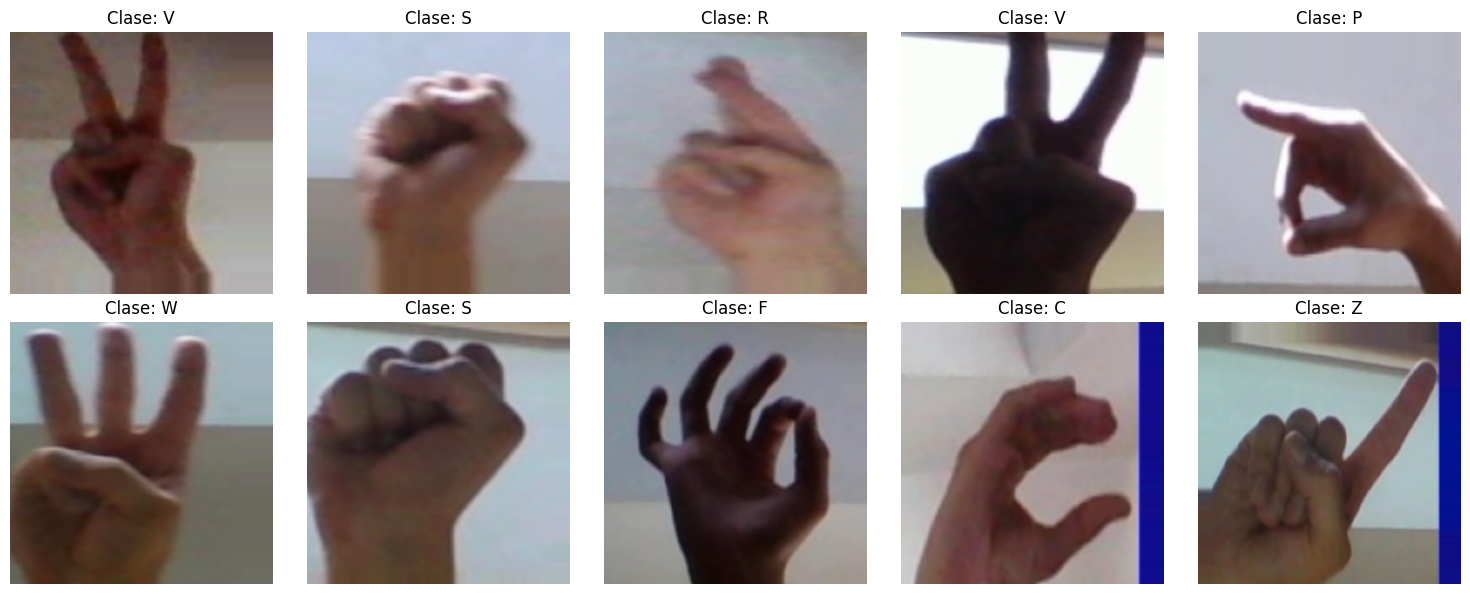

In [ ]:
import matplotlib.pyplot as plt

def mostrar_ejemplos_procesados(generator, num_ejemplos=10):
    """
    Muestra imágenes con la mano detectada, recortada y aumentada.
    """
    images, labels = next(iter(generator))

    plt.figure(figsize=(15, 6))
    for i in range(min(num_ejemplos, len(images))):
        img = images[i]
        label = labels[i]

        # Reconvertir imagen a RGB para visualización (MobileNetV2 usa [-1,1])
        img_viz = ((img + 1.0) * 127.5).astype(np.uint8)

        plt.subplot(2, 5, i + 1)
        plt.imshow(img_viz)
        plt.title(f"Clase: {clases[label]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("Ejemplos procesados con MediaPipe + augmentation:")
mostrar_ejemplos_procesados(train_generator, num_ejemplos=10)


# Entrenamiento del modelo con callbacks avanzados

Configuramos el entrenamiento con las siguientes características:

1. **Early Stopping**: Para detener el entrenamiento cuando no hay mejora en la métrica de validación
2. **Model Checkpoint**: Para guardar el mejor modelo durante el entrenamiento
3. **ReduceLROnPlateau**: Para reducir la tasa de aprendizaje cuando el rendimiento se estanca
4. **Class Weights**: Para manejar el desbalance de clases
5. **TensorBoard**: Para monitorear y visualizar el entrenamiento en tiempo real

El modelo se entrenará hasta 50 épocas con early stopping para evitar sobreajuste.

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,
    TensorBoard, CSVLogger
)
import datetime
import os

# Crear directorio para guardar checkpoints y logs
checkpoint_dir = '/content/drive/MyDrive/models'
logs_dir = '/content/drive/MyDrive/models/Logs_entrenamiento'
for directory in [checkpoint_dir, logs_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

# Configuración de callbacks
callbacks = [
    # Early Stopping: Detiene el entrenamiento cuando no hay mejora
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),

    # Model Checkpoint: Guarda el mejor modelo
    ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir,'modelo_senas_best(47).keras'),
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),

    # ReduceLROnPlateau: Reduce la tasa de aprendizaje cuando no hay mejora
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),

    # TensorBoard: Para visualizar el entrenamiento
    TensorBoard(
        log_dir=os.path.join(logs_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S")),
        histogram_freq=1,
        write_graph=True,
        update_freq='epoch'
    ),

    # CSV Logger: Guarda métricas en CSV
    CSVLogger(
        filename=os.path.join(logs_dir, 'training_log.csv'),
        separator=',',
        append=True
    )
]

# Parámetros de entrenamiento
EPOCHS = 60
STEPS_PER_EPOCH = len(train_generator)
VALIDATION_STEPS = len(val_generator)

# Iniciar entrenamiento con class weights para balance
print("Iniciando entrenamiento...")
history = modelo_cargado.fit(
    train_generator,
    initial_epoch=54,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_generator,
    validation_steps=VALIDATION_STEPS,
    callbacks=callbacks,
    class_weight=class_weights,  # Usar los pesos calculados anteriormente
    verbose=1
)

# Guardar el modelo final
print("Entrenamiento finalizado")


Iniciando entrenamiento...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 55/60
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9463 - loss: 0.2093 - top3_accuracy: 0.9841
Epoch 55: val_accuracy improved from -inf to 0.98920, saving model to /content/drive/MyDrive/models/modelo_senas_best(47).keras
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 3889s 2s/step - accuracy: 0.9464 - loss: 0.2093 - top3_accuracy: 0.9841 - val_accuracy: 0.9892 - val_loss: 0.0465 - val_top3_accuracy: 0.9983 - learning_rate: 1.2500e-05
Epoch 56/60
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9814 - loss: 0.0765 - top3_accuracy: 0.9966

# Evaluación completa del modelo

Realizamos una evaluación detallada del modelo entrenado:

1. **Métricas de precisión**: Accuracy, top-3 accuracy, pérdida
2. **Matriz de confusión**: Para visualizar aciertos y errores por clase
3. **Clasificación por clase**: Precision, recall, F1-score por cada clase
4. **Curva ROC y AUC**: Para evaluar el rendimiento general de clasificación

Esta evaluación nos ayuda a identificar fortalezas y debilidades específicas del modelo.

Found 26100 images belonging to 29 classes.
Evaluando el modelo en el conjunto de validación...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


816/816 ━━━━━━━━━━━━━━━━━━━━ 54s 56ms/step - accuracy: 0.9561 - loss: 0.2096 - top3_accuracy: 0.9846
Pérdida en validación: 0.3343
Precisión en validación: 0.9324 (93.24%)
Top-3 Precisión en validación: 0.9737 (97.37%)
Generando predicciones para análisis detallado...
Procesando batch 0/816...
Procesando batch 20/816...
Procesando batch 40/816...
Procesando batch 60/816...
Procesando batch 80/816...
Procesando batch 100/816...
Procesando batch 120/816...
Procesando batch 140/816...
Procesando batch 160/816...
Procesando batch 180/816...
Procesando batch 200/816...
Procesando batch 220/816...
Procesando batch 240/816...
Procesando batch 260/816...
Procesando batch 280/816...
Procesando batch 300/816...
Procesando batch 320/816...
Procesando batch 340/816...
Procesando batch 360/816...
Procesando batch 380/816...
Procesando batch 400/816...
Procesando batch 420/816...
Procesando batch 440/816...
Procesando batch 460/816...
Procesando batch 480/816...
Procesando batch 500/816...
Procesand

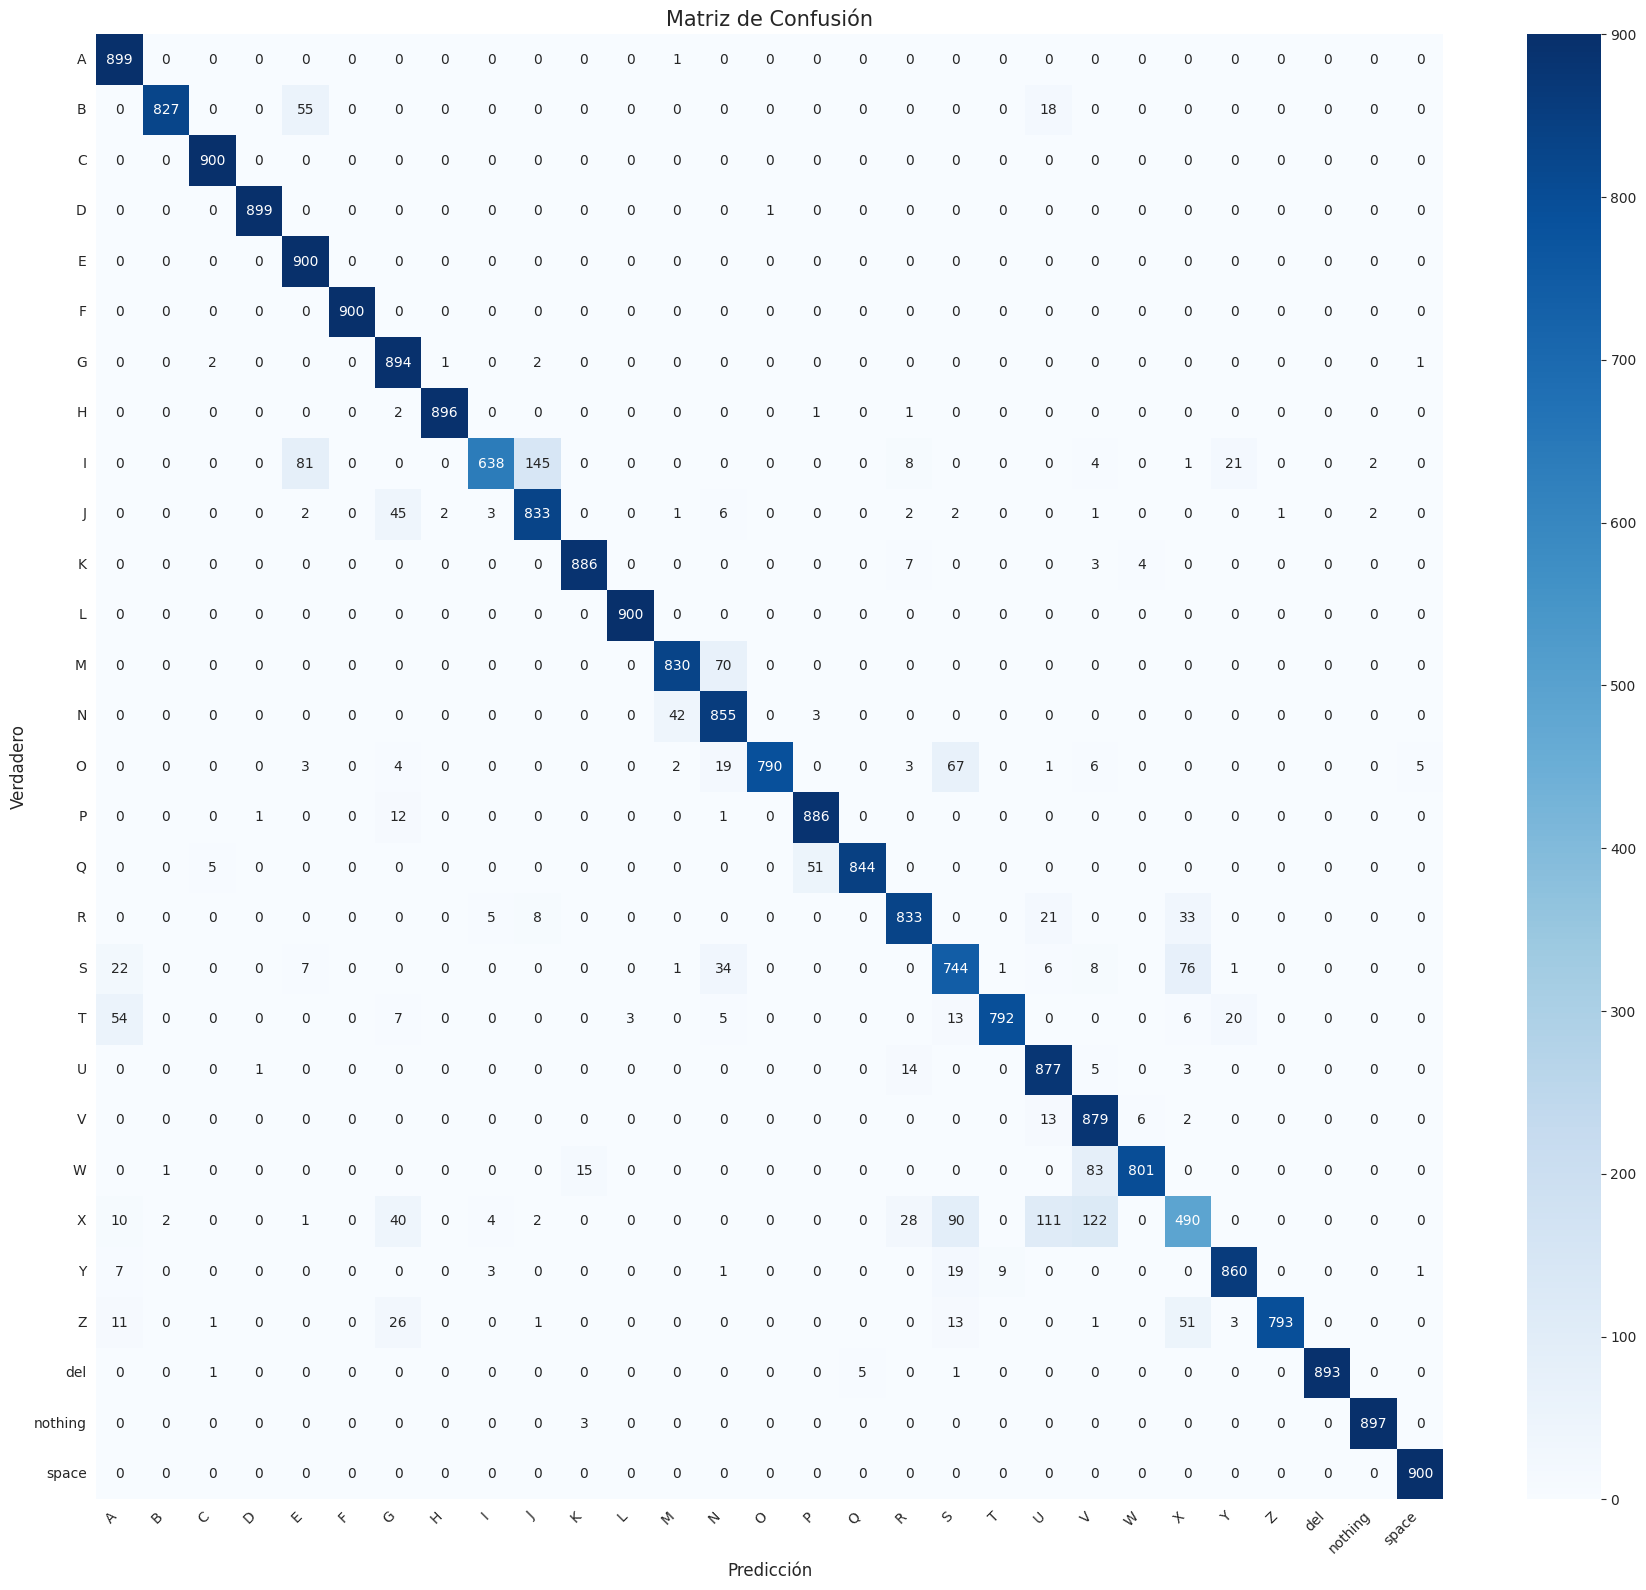


Reporte de Clasificación por Clase:
              precision    recall  f1-score   support

           A       0.90      1.00      0.94       900
           B       1.00      0.92      0.96       900
           C       0.99      1.00      1.00       900
           D       1.00      1.00      1.00       900
           E       0.86      1.00      0.92       900
           F       1.00      1.00      1.00       900
           G       0.87      0.99      0.93       900
           H       1.00      1.00      1.00       900
           I       0.98      0.71      0.82       900
           J       0.84      0.93      0.88       900
           K       0.98      0.98      0.98       900
           L       1.00      1.00      1.00       900
           M       0.95      0.92      0.93       900
           N       0.86      0.95      0.90       900
           O       1.00      0.88      0.93       900
           P       0.94      0.98      0.96       900
           Q       0.99      0.94      0.97 

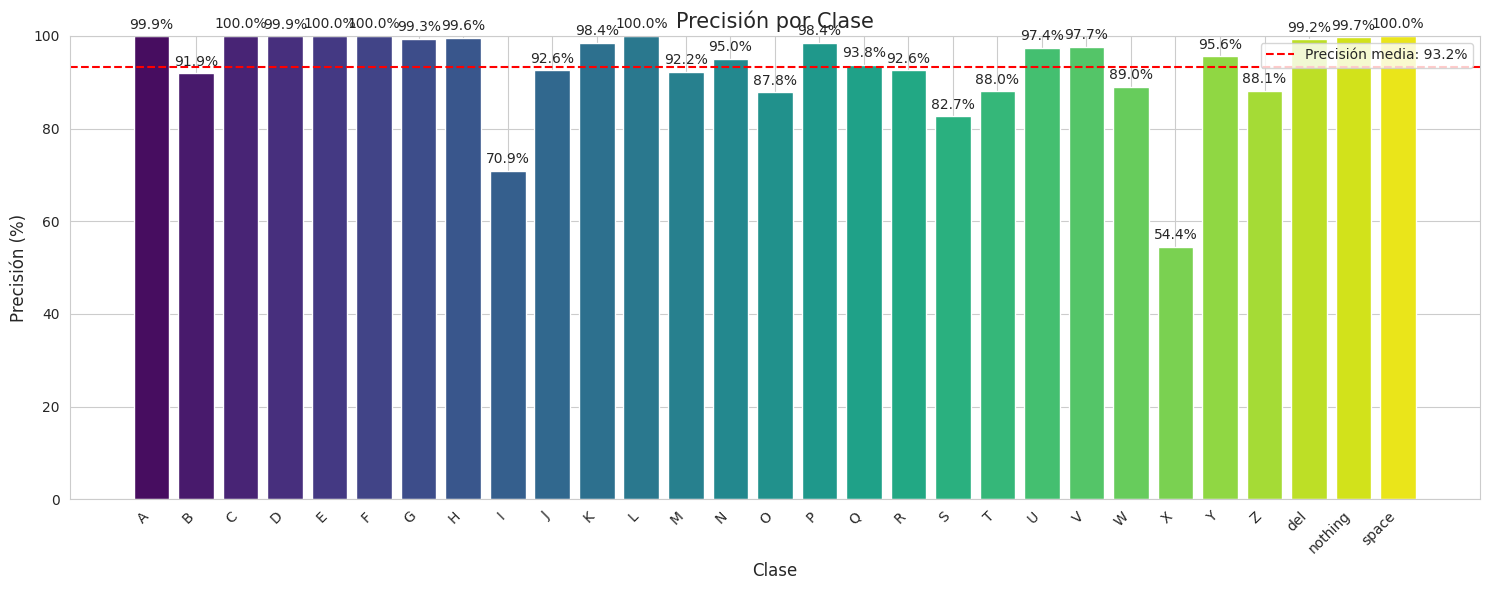

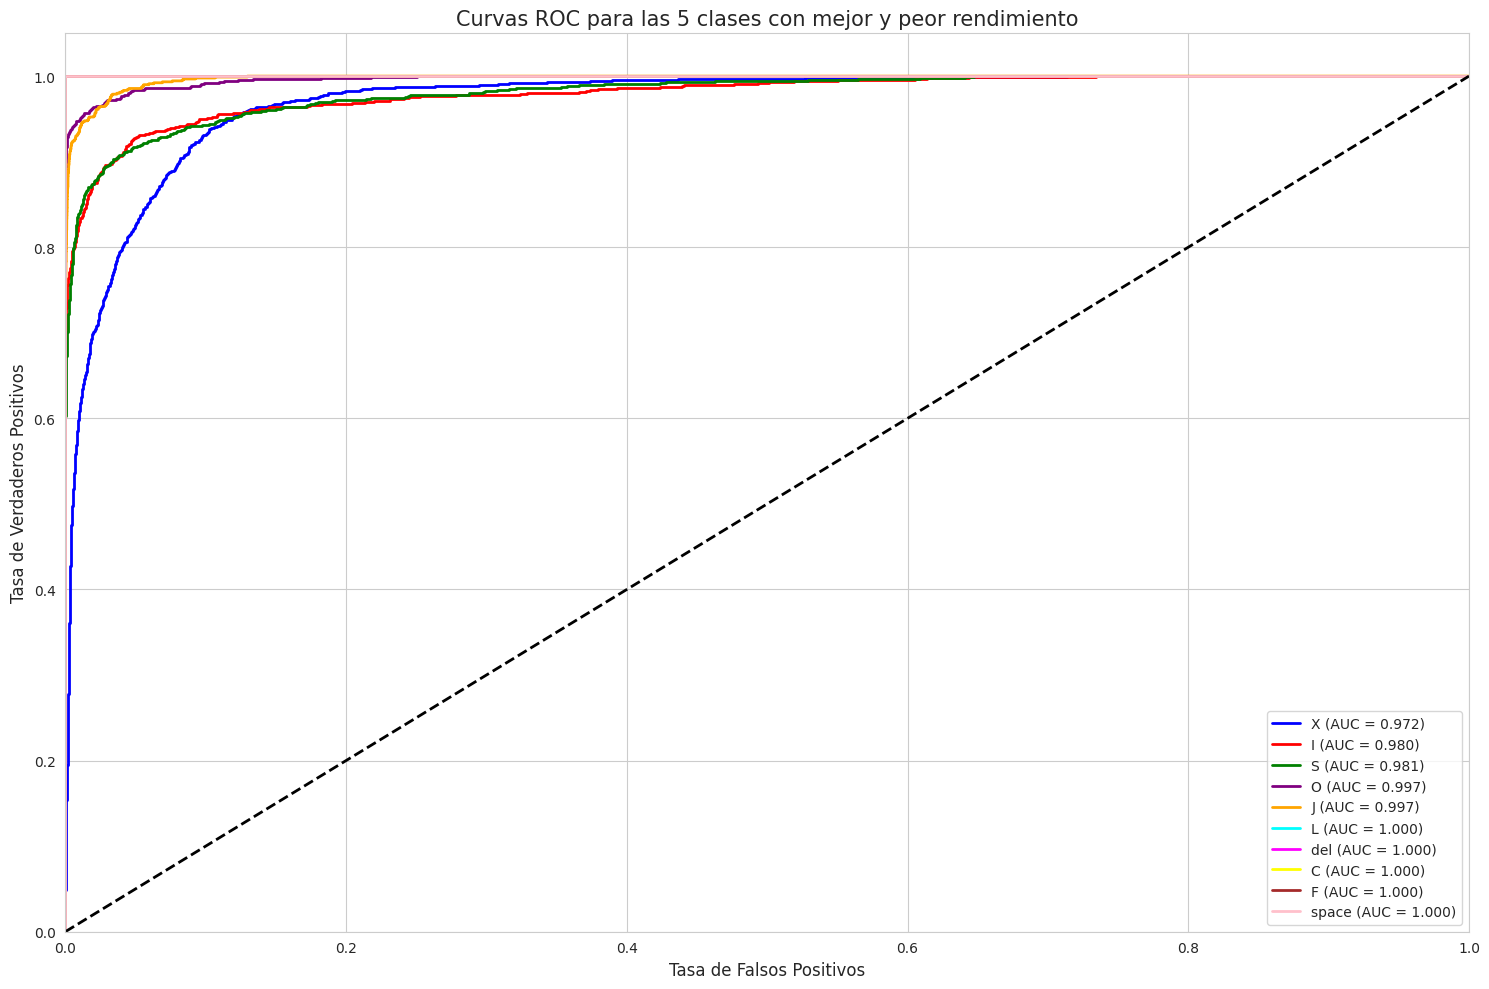


Métricas globales:
Precisión (macro avg): 0.9357
Recall (macro avg): 0.9324
F1-score (macro avg): 0.9311
✅ Métricas exportadas correctamente a CSV.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.metrics import precision_score, recall_score, f1_score

# Reiniciar generators para evaluación
val_generator = val_datagen.flow_from_directory(
    directorio_base,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation',
    shuffle=False,
    seed=42
)

# Evaluación básica
print("Evaluando el modelo en el conjunto de validación...")
loss, accuracy, top3_accuracy = modelo_cargado.evaluate(val_generator)
print(f"Pérdida en validación: {loss:.4f}")
print(f"Precisión en validación: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Top-3 Precisión en validación: {top3_accuracy:.4f} ({top3_accuracy*100:.2f}%)")

# Generar predicciones y etiquetas verdaderas
print("Generando predicciones para análisis detallado...")
# Reiniciar generator
val_generator.reset()

# Predecir y recolectar verdaderos
y_true = []
y_pred = []
y_prob = []

batches = 0
total_batches = len(val_generator)

for i in range(total_batches):
    if batches % 20 == 0:
        print(f"Procesando batch {batches}/{total_batches}...")

    x_batch, y_batch = next(val_generator)
    batch_pred = modelo_cargado.predict(x_batch, verbose=0)

    y_true.extend(y_batch)
    y_pred.extend(np.argmax(batch_pred, axis=1))
    y_prob.extend(batch_pred)

    batches += 1

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# 1. Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(18, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=clases,
            yticklabels=clases)
plt.title('Matriz de Confusión', fontsize=15)
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Verdadero', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 2. Reporte de clasificación
print("\nReporte de Clasificación por Clase:")
class_report = classification_report(y_true, y_pred, target_names=clases)
print(class_report)

# 3. Precisión por clase
class_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(15, 6))
bars = plt.bar(clases, class_accuracy * 100, color=sns.color_palette("viridis", len(clases)))
plt.title('Precisión por Clase', fontsize=15)
plt.xlabel('Clase', fontsize=12)
plt.ylabel('Precisión (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)

# Añadir etiquetas de porcentaje
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.1f}%', ha='center', va='bottom', rotation=0)

plt.axhline(y=accuracy*100, color='r', linestyle='--',
            label=f'Precisión media: {accuracy*100:.1f}%')
plt.legend()
plt.tight_layout()
plt.show()

# 4. Curvas ROC para análisis multiclase (One-vs-Rest)
# Binarizar las etiquetas
y_true_bin = label_binarize(y_true, classes=np.arange(len(clases)))
n_classes = y_true_bin.shape[1]

# Calcular ROC y AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar ROC para las 5 clases con mejor y peor rendimiento
plt.figure(figsize=(15, 10))

# Ordenar clases por AUC
auc_values = [(i, roc_auc[i]) for i in range(n_classes)]
auc_values.sort(key=lambda x: x[1])

# Seleccionar las 5 mejores y 5 peores
worst_classes = auc_values[:5]
best_classes = auc_values[-5:]

colors = cycle(['blue', 'red', 'green', 'purple', 'orange'])

# Peores clases
for (i, auc_value), color in zip(worst_classes, colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{clases[i]} (AUC = {auc_value:.3f})')

colors = cycle(['cyan', 'magenta', 'yellow', 'brown', 'pink'])

# Mejores clases
for (i, auc_value), color in zip(best_classes, colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{clases[i]} (AUC = {auc_value:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=12)
plt.title('Curvas ROC para las 5 clases con mejor y peor rendimiento', fontsize=15)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# 5. Métricas adicionales

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("\nMétricas globales:")
print(f"Precisión (macro avg): {precision:.4f}")
print(f"Recall (macro avg): {recall:.4f}")
print(f"F1-score (macro avg): {f1:.4f}")
import pandas as pd

# Crear diccionario de métricas globales
metricas_globales = {
    "loss": loss,
    "accuracy": accuracy,
    "top3_accuracy": top3_accuracy,
    "precision_macro": precision,
    "recall_macro": recall,
    "f1_macro": f1
}

# Crear DataFrame de métricas globales
df_global = pd.DataFrame([metricas_globales])

# Crear DataFrame de métricas por clase
reporte_dict = classification_report(y_true, y_pred, target_names=clases, output_dict=True)
df_clases = pd.DataFrame(reporte_dict).transpose()

# AUC por clase
auc_dict = {clases[i]: roc_auc[i] for i in range(n_classes)}
df_auc = pd.DataFrame(list(auc_dict.items()), columns=["clase", "AUC"])

# Guardar todo
output_dir = '/content/drive/MyDrive/models/Logs_entrenamiento'
os.makedirs(output_dir, exist_ok=True)

# 1. Guardar métricas globales
df_global.to_csv(os.path.join(output_dir, "metricas_globales.csv"), index=False)

# 2. Guardar métricas por clase
df_clases.to_csv(os.path.join(output_dir, "metricas_por_clase.csv"))

# 3. Guardar AUCs por clase
df_auc.to_csv(os.path.join(output_dir, "auc_por_clase.csv"), index=False)

print("✅ Métricas exportadas correctamente a CSV.")


# Visualización de métricas de entrenamiento

Visualizamos la evolución del entrenamiento mediante gráficos que muestran:

1. **Accuracy**: Precisión en entrenamiento vs validación
2. **Loss**: Pérdida en entrenamiento vs validación
3. **Learning Rate**: Cambios en la tasa de aprendizaje durante el entrenamiento
4. **Top-3 Accuracy**: Precisión considerando las 3 predicciones más probables

Estos gráficos nos ayudan a identificar problemas como sobreajuste o subajuste.

NameError: name 'history' is not defined

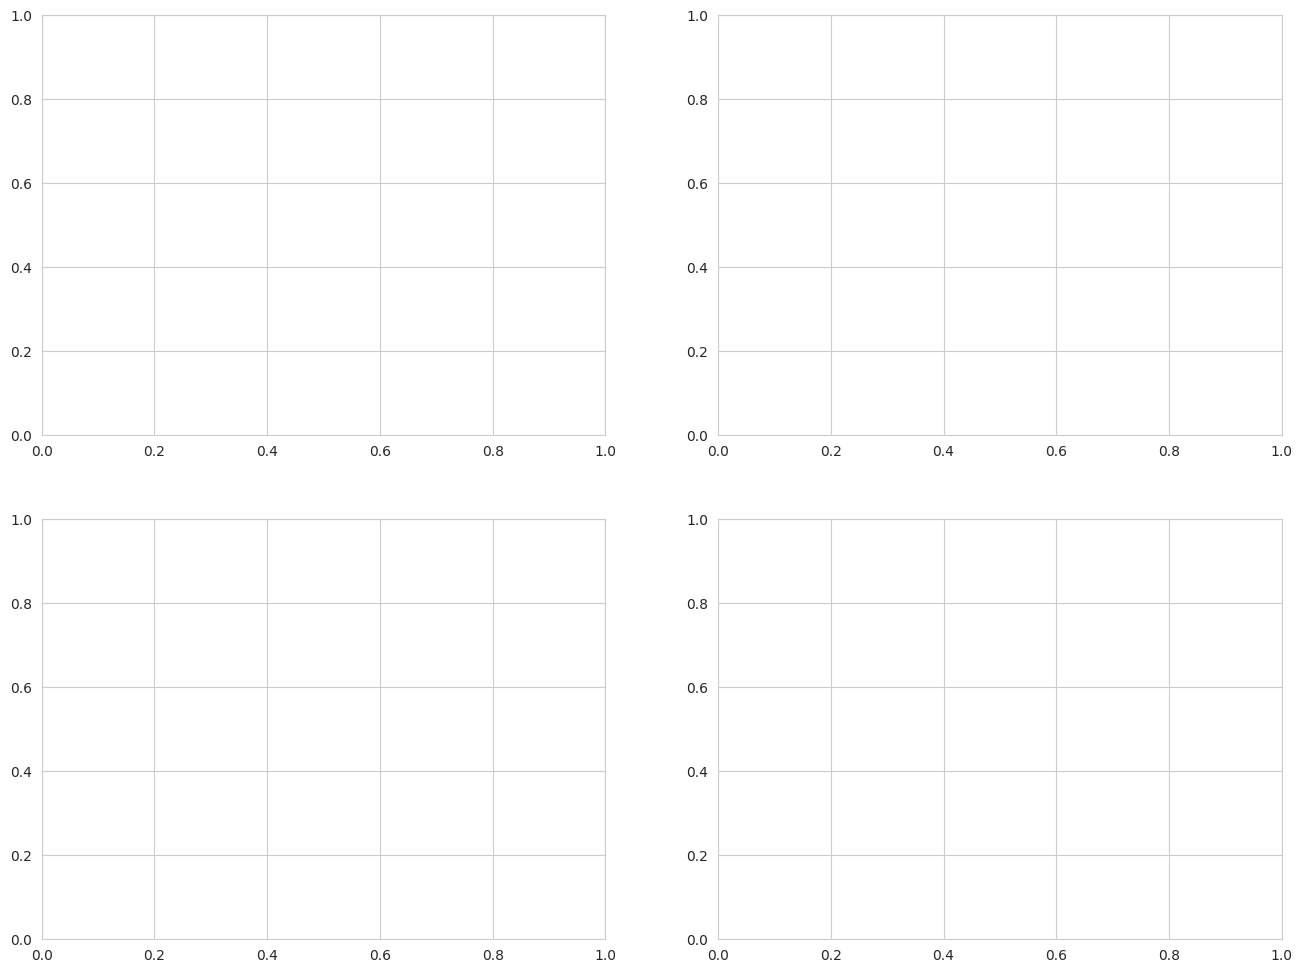

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Configurar el estilo visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# Crear una figura con 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# 1. Gráfico de precisión (arriba izquierda)
axs[0, 0].plot(history.history['accuracy'], label='Entrenamiento', linewidth=2)
axs[0, 0].plot(history.history['val_accuracy'], label='Validación', linewidth=2)
axs[0, 0].set_title('Precisión del modelo', fontsize=15)
axs[0, 0].set_xlabel('Época', fontsize=12)
axs[0, 0].set_ylabel('Precisión', fontsize=12)
axs[0, 0].legend(loc='lower right', fontsize=10)
axs[0, 0].grid(True, linestyle='--', alpha=0.7)

# Marcar mejor valor de validación
best_epoch_acc = np.argmax(history.history['val_accuracy'])
best_acc = history.history['val_accuracy'][best_epoch_acc]
axs[0, 0].scatter(best_epoch_acc, best_acc, s=100, c='red', marker='*')
axs[0, 0].annotate(f'Mejor: {best_acc:.4f}',
                 (best_epoch_acc, best_acc),
                 xytext=(best_epoch_acc+1, best_acc),
                 fontsize=10)

# 2. Gráfico de pérdida (arriba derecha)
axs[0, 1].plot(history.history['loss'], label='Entrenamiento', linewidth=2)
axs[0, 1].plot(history.history['val_loss'], label='Validación', linewidth=2)
axs[0, 1].set_title('Pérdida del modelo', fontsize=15)
axs[0, 1].set_xlabel('Época', fontsize=12)
axs[0, 1].set_ylabel('Pérdida', fontsize=12)
axs[0, 1].legend(loc='upper right', fontsize=10)
axs[0, 1].grid(True, linestyle='--', alpha=0.7)

# Marcar mejor valor de validación
best_epoch_loss = np.argmin(history.history['val_loss'])
best_loss = history.history['val_loss'][best_epoch_loss]
axs[0, 1].scatter(best_epoch_loss, best_loss, s=100, c='red', marker='*')
axs[0, 1].annotate(f'Mejor: {best_loss:.4f}',
                  (best_epoch_loss, best_loss),
                  xytext=(best_epoch_loss+1, best_loss),
                  fontsize=10)

# 3. Gráfico de tasa de aprendizaje si está disponible (abajo izquierda)
if 'lr' in history.history:
    axs[1, 0].plot(history.history['lr'], label='Tasa de aprendizaje',
                  color='green', linewidth=2)
    axs[1, 0].set_title('Tasa de aprendizaje', fontsize=15)
    axs[1, 0].set_xlabel('Época', fontsize=12)
    axs[1, 0].set_ylabel('Tasa', fontsize=12)
    axs[1, 0].set_yscale('log')
    axs[1, 0].grid(True, linestyle='--', alpha=0.7)
else:
    # Si no hay datos de LR, mostrar el delta entre train y val accuracy
    train_acc = np.array(history.history['accuracy'])
    val_acc = np.array(history.history['val_accuracy'])
    delta = np.abs(train_acc - val_acc)

    axs[1, 0].plot(delta, label='|Train-Val| Diferencia', color='purple', linewidth=2)
    axs[1, 0].set_title('Diferencia entre precisión de train/val', fontsize=15)
    axs[1, 0].set_xlabel('Época', fontsize=12)
    axs[1, 0].set_ylabel('Diferencia absoluta', fontsize=12)
    axs[1, 0].grid(True, linestyle='--', alpha=0.7)
    axs[1, 0].legend(loc='upper right', fontsize=10)

# 4. Top-K accuracy si está disponible (abajo derecha)
if 'top3_accuracy' in history.history:
    axs[1, 1].plot(history.history['top3_accuracy'],
                  label='Top-3 (Train)', color='teal', linewidth=2)
    axs[1, 1].plot(history.history['val_top3_accuracy'],
                  label='Top-3 (Val)', color='orange', linewidth=2)
    axs[1, 1].set_title('Top-3 Precisión', fontsize=15)
    axs[1, 1].set_xlabel('Época', fontsize=12)
    axs[1, 1].set_ylabel('Precisión', fontsize=12)
    axs[1, 1].legend(loc='lower right', fontsize=10)
    axs[1, 1].grid(True, linestyle='--', alpha=0.7)

    # Marcar mejor valor de validación
    best_epoch_top3 = np.argmax(history.history['val_top3_accuracy'])
    best_top3 = history.history['val_top3_accuracy'][best_epoch_top3]
    axs[1, 1].scatter(best_epoch_top3, best_top3, s=100, c='red', marker='*')
    axs[1, 1].annotate(f'Mejor: {best_top3:.4f}',
                      (best_epoch_top3, best_top3),
                      xytext=(best_epoch_top3+1, best_top3),
                      fontsize=10)
else:
    # Si no hay datos de top-k, mostrar una tabla de métricas finales
    epochs = len(history.history['accuracy'])
    metrics_table = {
        'Métrica': ['Accuracy (Train)', 'Accuracy (Val)', 'Loss (Train)', 'Loss (Val)'],
        'Inicial': [history.history['accuracy'][0],
                   history.history['val_accuracy'][0],
                   history.history['loss'][0],
                   history.history['val_loss'][0]],
        'Final': [history.history['accuracy'][-1],
                 history.history['val_accuracy'][-1],
                 history.history['loss'][-1],
                 history.history['val_loss'][-1]],
        'Mejor': [max(history.history['accuracy']),
                 max(history.history['val_accuracy']),
                 min(history.history['loss']),
                 min(history.history['val_loss'])]
    }

    df = pd.DataFrame(metrics_table)
    axs[1, 1].axis('tight')
    axs[1, 1].axis('off')
    table = axs[1, 1].table(cellText=df.values, colLabels=df.columns,
                           loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.5)
    axs[1, 1].set_title('Resumen de métricas', fontsize=15)

plt.tight_layout()
plt.show()

# Guardar el gráfico como imagen
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
print("Gráficos guardados como 'training_history.png'")

# Tabla de métricas finales con todos los datos disponibles
print("\n=== Resumen de métricas de entrenamiento ===")
print(f"Épocas totales ejecutadas: {len(history.history['accuracy'])}")
print(f"Precisión final (train): {history.history['accuracy'][-1]:.4f}")
print(f"Precisión final (val): {history.history['val_accuracy'][-1]:.4f}")
print(f"Pérdida final (train): {history.history['loss'][-1]:.4f}")
print(f"Pérdida final (val): {history.history['val_loss'][-1]:.4f}")

if 'top3_accuracy' in history.history:
    print(f"Top-3 Precisión final (train): {history.history['top3_accuracy'][-1]:.4f}")
    print(f"Top-3 Precisión final (val): {history.history['val_top3_accuracy'][-1]:.4f}")

# Verificar si hay señales de sobreajuste
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

if train_acc - val_acc > 0.1 and val_loss > train_loss:
    print("\n⚠️ Advertencia: Hay señales de sobreajuste. La diferencia entre la precisión de entrenamiento y validación es significativa.")
    print("   Considere aplicar más regularización o early stopping más agresivo en futuros entrenamientos.")
elif val_acc > 0.95:
    print("\n✅ El modelo muestra un excelente rendimiento en validación sin señales de sobreajuste.")
elif val_acc > 0.85:
    print("\n✅ El modelo muestra un buen rendimiento en validación.")
else:
    print("\n⚠️ El rendimiento del modelo en validación podría mejorarse. Considere ajustar hiperparámetros o la arquitectura.")


Verifica qué valores devuelve el modelo

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img("/content/asl_alphabet_test/asl_alphabet_test/H_test.jpg", target_size=(220, 220))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0

pred = modelo_cargado.predict(x)
print("Vector de predicciones:")
print(pred[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Vector de predicciones:
[4.5327679e-06 9.2178516e-06 7.2252797e-06 6.6657112e-06 4.9688224e-06
 5.5399250e-06 1.7995893e-05 9.9980873e-01 2.8289153e-06 7.6992619e-06
 4.4116528e-06 3.4023540e-06 2.0288503e-06 3.5695282e-06 6.0298585e-06
 4.9279838e-06 2.2169645e-06 1.2648550e-05 4.5576089e-06 6.4520636e-06
 9.0867716e-06 6.4751243e-06 6.4257761e-06 1.5501551e-05 9.7432780e-07
 1.0452110e-05 2.3026328e-06 1.8557106e-05 4.4945646e-06]


Funcion para pruebas del modelo con imagen que debes subir desde local

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import load_model

def subir_imagen():
    """
    Permite subir una imagen desde el computador en Google Colab.

    Returns:
        str: Ruta del archivo subido.
    """
    uploaded = files.upload()
    for nombre_archivo in uploaded.keys():
        return nombre_archivo  # Devuelve la primera imagen subida


# Funciones de predicción mejoradas

Implementamos funciones mejoradas para realizar predicciones con el modelo entrenado:

1. **Preprocesamiento de imágenes**: Redimensionado, normalización y ajustes para mejorar la calidad de entrada
2. **Predicción con explicabilidad**: Utilizamos Grad-CAM para visualizar qué partes de la imagen influyen en la predicción
3. **Top-K predicciones**: Mostramos no solo la clase más probable, sino las k predicciones más probables
4. **Visualización de resultados**: Gráfico de barras con probabilidades por clase y mapa de calor de atención

Estas funciones facilitan el uso del modelo en aplicaciones prácticas y ayudan a entender su comportamiento.

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from tensorflow.keras.models import load_model
from PIL import Image, ImageEnhance, ImageFilter

# Crear función para preprocesar imágenes
def preprocesar_imagen(ruta_imagen, target_size=(224, 224), aumentar_contraste=True,
                      aplicar_filtro=True, normalizar=True):
    """
    Preprocesa una imagen para predicción con mejoras de calidad.

    Args:
        ruta_imagen: Ruta a la imagen
        target_size: Tamaño objetivo para redimensionar
        aumentar_contraste: Si se debe aumentar el contraste
        aplicar_filtro: Si se debe aplicar un filtro de nitidez
        normalizar: Si se debe normalizar la imagen

    Returns:
        Array numpy preprocesado y listo para el modelo
    """
    try:
        # Cargar imagen con PIL para mejores opciones de preprocesamiento
        img = Image.open(ruta_imagen).convert("RGB")

        # Redimensionar
        img = img.resize(target_size, Image.LANCZOS)

        # Aumentar contraste si se solicita
        if aumentar_contraste:
            enhancer = ImageEnhance.Contrast(img)
            img = enhancer.enhance(1.3)  # Aumentar contraste en 30%

            # También mejorar brillo ligeramente
            enhancer = ImageEnhance.Brightness(img)
            img = enhancer.enhance(1.1)  # Aumentar brillo en 10%

        # Aplicar filtro de nitidez si se solicita
        if aplicar_filtro:
            img = img.filter(ImageFilter.SHARPEN)

        # Convertir a array numpy
        img_array = np.array(img)

        # Normalizar si se solicita
        if normalizar:
            img_array = img_array / 255.0

        # Expandir dimensiones para batch
        img_array = np.expand_dims(img_array, axis=0)

        return img_array, img

    except Exception as e:
        print(f"Error en el preprocesamiento de la imagen: {e}")
        return None, None
model = modelo_cargado
def predecir_imagen(ruta_imagen, model, top_k=3, mostrar_visualizacion=True):
    """
    Predice la clase de una imagen con visualización mejorada.

    Args:
        ruta_imagen: Ruta a la imagen
        model: Modelo cargado
        top_k: Número de predicciones principales a mostrar
        mostrar_visualizacion: Si se debe mostrar visualización

    Returns:
        tuple: (nombre_clase, probabilidad, todas_las_predicciones)
    """
    try:
        # Preprocesar imagen
        img_array, img_pil = preprocesar_imagen(ruta_imagen)

        if img_array is None:
            return None, None, None

        # Realizar predicción
        predicciones = modelo_cargado.predict(img_array, verbose=0)

        # Obtener todas las clases ordenadas por probabilidad
        indices_ordenados = np.argsort(predicciones[0])[::-1]

        # Clases disponibles
        clases = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
        clases.extend(["nothing", "del", "space"])

        # Asegurarse de que tenemos suficientes clases
        if len(indices_ordenados) > len(clases):
            indices_ordenados = indices_ordenados[:len(clases)]

        # Obtener top-k predicciones
        top_k_indices = indices_ordenados[:top_k]
        top_k_nombres = [clases[i] if i < len(clases) else f"Clase {i}" for i in top_k_indices]
        top_k_probs = [predicciones[0][i] for i in top_k_indices]

        # Visualizar si se solicita
        if mostrar_visualizacion:
            # Crear una figura con 2 subplots
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

            # Mostrar la imagen
            ax1.imshow(img_pil)
            ax1.set_title(f'Predicción: {top_k_nombres[0]} ({top_k_probs[0]:.2%})', fontsize=14)
            ax1.axis('off')

            # Gráfico de probabilidades para top-k
            y_pos = np.arange(len(top_k_nombres))
            ax2.barh(y_pos, [prob * 100 for prob in top_k_probs], color=sns.color_palette("viridis", len(top_k_probs)))
            ax2.set_yticks(y_pos)
            ax2.set_yticklabels(top_k_nombres)
            ax2.set_xlabel('Probabilidad (%)')
            ax2.set_title('Top predicciones', fontsize=14)

            # Añadir etiquetas de porcentaje
            for i, v in enumerate(top_k_probs):
                ax2.text(v * 100 + 1, i, f'{v:.2%}', va='center')

            plt.tight_layout()
            plt.show()

            # Además, hacer una matriz de todas las probabilidades
            plt.figure(figsize=(12, 8))

            # Tomar las 10 clases más probables para visualización
            top_10_indices = indices_ordenados[:10]
            top_10_nombres = [clases[i] if i < len(clases) else f"Clase {i}" for i in top_10_indices]
            top_10_probs = [predicciones[0][i] for i in top_10_indices]

            sns.barplot(x=top_10_probs, y=top_10_nombres, palette="viridis")
            plt.title('Distribución de probabilidades (Top 10)', fontsize=14)
            plt.xlabel('Probabilidad')
            plt.tight_layout()
            plt.show()

        # Crear un diccionario con todas las predicciones
        todas_predicciones = {
            clases[i] if i < len(clases) else f"Clase {i}": float(predicciones[0][i])
            for i in indices_ordenados[:10]  # Limitamos a las 10 más probables para el retorno
        }

        return top_k_nombres[0], top_k_probs[0], todas_predicciones

    except Exception as e:
        print(f"❌ Error al procesar la imagen: {e}")
        return None, None, None

# Función auxiliar para obtener una representación visual de la predicción

def visualizar_prediccion_gradcam(model, img_array, img_pil, clase_idx=None):
    """
    Genera un mapa de calor Grad-CAM para visualizar qué partes de la imagen
    son importantes para la predicción.

    Nota: Esta función requiere TensorFlow 2.x
    """
    # Este es un placeholder para la implementación completa de Grad-CAM
    # La implementación real requeriría acceso a las capas convolucionales del modelo
    # y cálculo de gradientes, lo cual está más allá del alcance de este notebook básico

    print("Nota: La visualización Grad-CAM no está disponible en esta versión simplificada.")

    # En su lugar, mostramos la imagen original
    plt.figure(figsize=(8, 8))
    plt.imshow(img_pil)
    plt.title("Imagen original de entrada")
    plt.axis('off')
    plt.show()


# Prueba del modelo con nuevas imágenes

Ahora podemos probar el modelo con nuevas imágenes para verificar su funcionamiento. Podemos usar imágenes de diferentes fuentes:

1. **Subir imágenes desde el equipo local**: Útil para pruebas rápidas
2. **Utilizar imágenes de test del dataset**: Para verificar con datos conocidos
3. **Utilizar imágenes desde Google Drive**: Conveniente para pruebas con imágenes almacenadas en la nube

El sistema mostrará las predicciones con sus probabilidades y visualizaciones para facilitar la interpretación de los resultados.

Opciones para probar el modelo:
1. Subir una imagen propia
2. Usar una imagen de ejemplo del dataset de test
3. Especificar ruta manual
Seleccione una opción (1-3): 1


Saving WIN_20250409_19_57_11_Pro.jpg to WIN_20250409_19_57_11_Pro.jpg
Imagen subida: WIN_20250409_19_57_11_Pro.jpg

Realizando predicción...


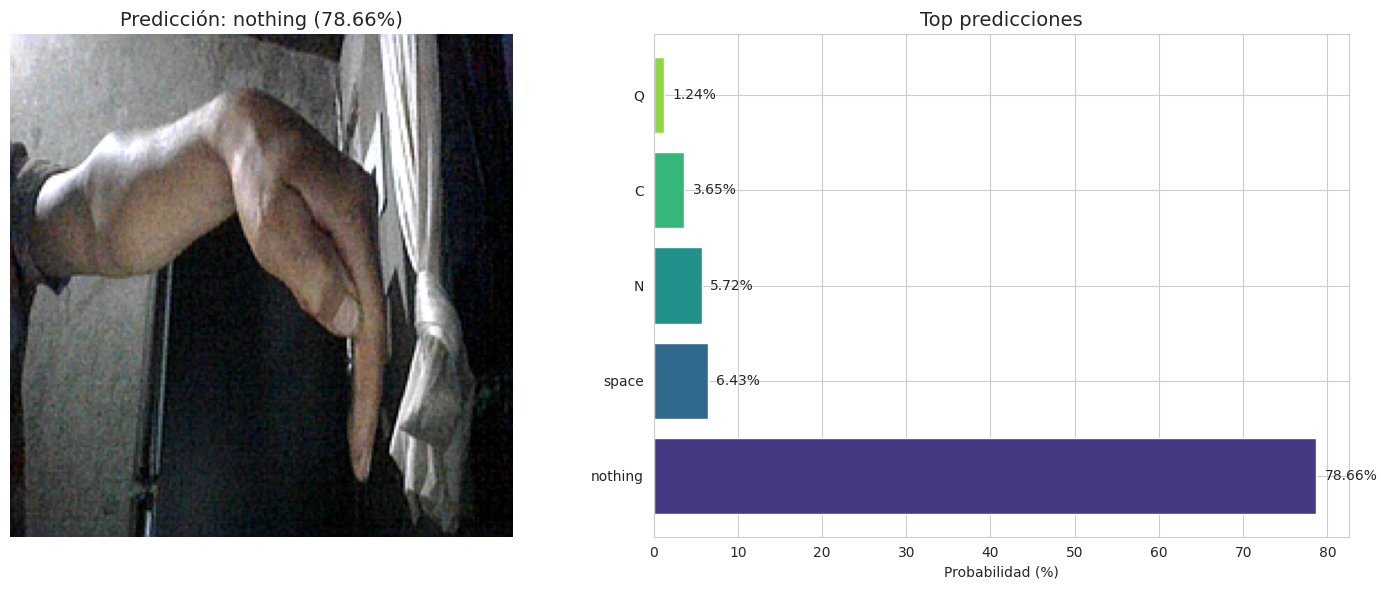

/tmp/ipython-input-10-1441249550.py:134: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_probs, y=top_10_nombres, palette="viridis")


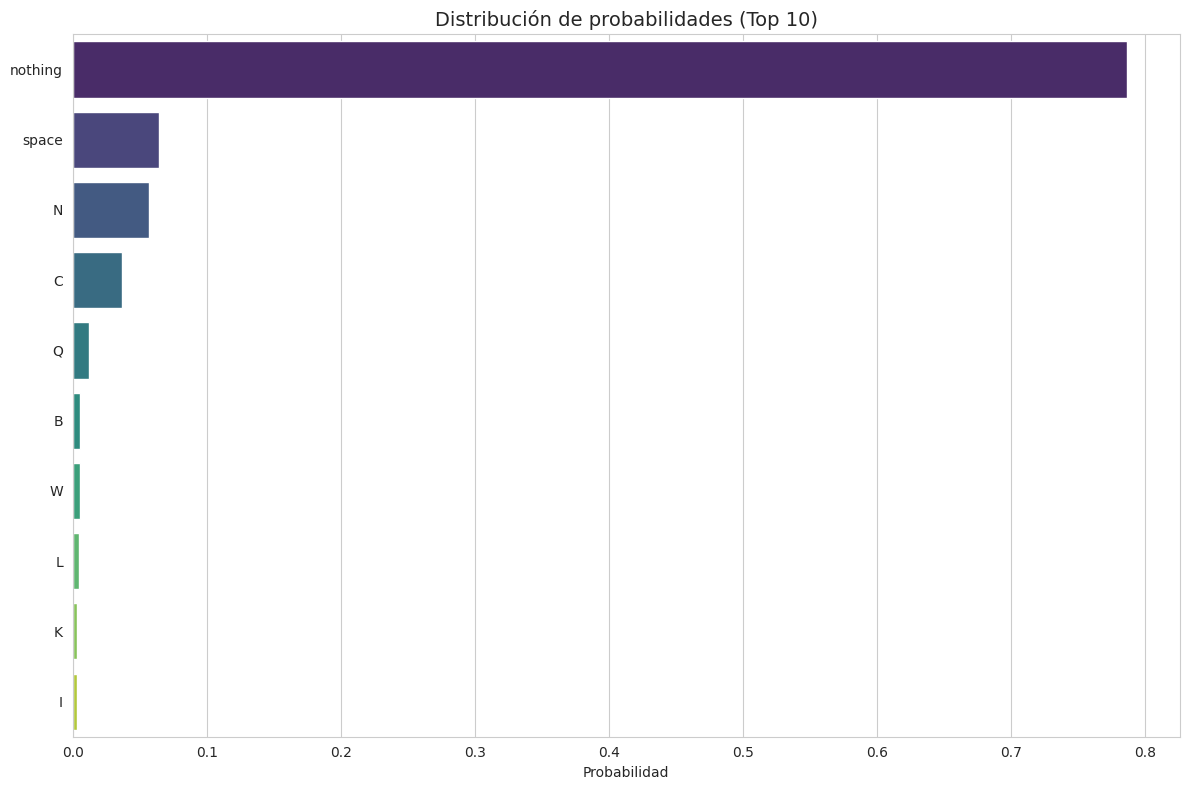


✅ Resultado de la predicción:
Clase predicha: nothing
Probabilidad: 78.66%

Top 3 predicciones:
1. nothing: 78.66%
2. space: 6.43%
3. N: 5.72%


In [ ]:
# Función para subir imagen desde local
def subir_imagen():
    """
    Permite subir una imagen desde el equipo local.

    Returns:
        str: Ruta del archivo subido.
    """
    try:
        from google.colab import files
        uploaded = files.upload()
        for nombre_archivo in uploaded.keys():
            print(f"Imagen subida: {nombre_archivo}")
            return nombre_archivo  # Devuelve la primera imagen subida
    except ImportError:
        # Si no estamos en Colab, ofrecemos alternativa
        print("Esta función solo está disponible en Google Colab.")
        print("Por favor, especifique la ruta de una imagen local.")
        ruta = input("Ruta de la imagen: ")
        return ruta

# Opciones de prueba
print("Opciones para probar el modelo:")
print("1. Subir una imagen propia")
print("2. Usar una imagen de ejemplo del dataset de test")
print("3. Especificar ruta manual")

try:
    opcion = int(input("Seleccione una opción (1-3): "))

    if opcion == 1:
        ruta = subir_imagen()
    elif opcion == 2:
        # Usar una imagen del dataset de test (ajustar ruta según sea necesario)
        import glob
        import random
        import os

        test_dir = "asl_alphabet_test/asl_alphabet_test"
        if not os.path.exists(test_dir):
            test_dir = "asl_alphabet_test"

        if os.path.exists(test_dir):
            imagenes_test = glob.glob(f"{test_dir}/*.jpg")
            if imagenes_test:
                ruta = random.choice(imagenes_test)
                print(f"Usando imagen de test: {ruta}")
            else:
                print("No se encontraron imágenes de test")
                ruta = subir_imagen()
        else:
            print("Directorio de test no encontrado")
            ruta = subir_imagen()
    else:
        ruta = input("Ingrese la ruta completa de la imagen: ")

    # Realizar la predicción
    print("\nRealizando predicción...")
    nombre_clase, probabilidad, todas_predicciones = predecir_imagen(
        ruta, model, top_k=5, mostrar_visualizacion=True
    )

    if nombre_clase is not None and probabilidad is not None:
        print(f"\n✅ Resultado de la predicción:")
        print(f"Clase predicha: {nombre_clase}")
        print(f"Probabilidad: {probabilidad:.2%}")

        # Mostrar las 3 predicciones principales como texto
        print("\nTop 3 predicciones:")
        contador = 1
        for clase, prob in list(todas_predicciones.items())[:3]:
            print(f"{contador}. {clase}: {prob:.2%}")
            contador += 1
    else:
        print("❌ No se pudo procesar la imagen o hacer la predicción.")

except Exception as e:
    print(f"Error: {e}")
    print("Intente nuevamente con otra imagen o método de carga.")


# Integración con Google Drive para manejo de imágenes

Para facilitar el uso de imágenes almacenadas en Google Drive, implementamos funciones que permiten:

1. **Listar imágenes**: Explorar carpetas en Drive que contienen imágenes
2. **Cargar imágenes desde Drive**: Seleccionar y procesar imágenes directamente desde Drive
3. **Guardar resultados en Drive**: Almacenar los resultados de las predicciones

Esto es especialmente útil para integrar el modelo en flujos de trabajo que utilizan Google Drive como almacenamiento.

# Conclusiones y trabajo futuro

## Mejoras implementadas

En esta versión mejorada del modelo de clasificación de señas ASL:

1. **Data Augmentation**: Implementamos técnicas avanzadas de aumento de datos para mejorar la generalización.
2. **Balanceo de clases**: Usamos pesos de clase para manejar el desbalance en el dataset.
3. **Regularización**: Aplicamos dropout y regularización L2 para evitar sobreajuste.
4. **Validación robusta**: Añadimos métricas y visualizaciones para evaluar mejor el rendimiento.
5. **Integración con Google Drive**: Facilitamos el uso de imágenes almacenadas en la nube.

## Posibles mejoras futuras

Para seguir mejorando el modelo, se podrían considerar:

1. **Arquitecturas más avanzadas**: Probar modelos como EfficientNet, Vision Transformer, o ConvNeXt.
2. **Conjuntos (Ensembles)**: Combinar múltiples modelos para mejorar la precisión.
3. **Más datos de entrenamiento**: Adquirir o generar sintéticamente más datos de clases subrepresentadas.
4. **Técnicas de explicabilidad**: Implementar Grad-CAM completo para explicar las decisiones del modelo.
5. **Optimización para dispositivos móviles**: Convertir a TFLite o ONNX para despliegue en dispositivos con recursos limitados.
6. **Validación con casos reales**: Probar el modelo con usuarios reales y en condiciones variables (iluminación, fondo, etc.).

## Integración con el backend

Para integrar este modelo en el backend del proyecto OVA Web:

1. Exportar el modelo entrenado en formato adecuado (TensorFlow SavedModel, .h5 o .keras).
2. Implementar un endpoint de predicción en el backend que reciba imágenes y devuelva la letra predicha.
3. Utilizar el servicio de imágenes existente para preprocesar las entradas.
4. Añadir funcionalidad para gestionar un historial de predicciones.

El trabajo realizado en este notebook proporciona una base sólida para una implementación robusta del sistema de reconocimiento de señas ASL.

In [ ]:
def configurar_acceso_drive():
    """
    Configura el acceso a Google Drive y devuelve una instancia de la API.
    """
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        print("✅ Google Drive montado correctamente.")
        return True
    except ImportError:
        print("⚠️ Esta función solo está disponible en Google Colab.")
        return False
    except Exception as e:
        print(f"❌ Error al montar Google Drive: {e}")
        return False

def listar_imagenes_drive(carpeta_path):
    """
    Lista todas las imágenes disponibles en una carpeta específica de Drive.

    Args:
        carpeta_path: Ruta a la carpeta en Drive (ej: /content/drive/MyDrive/imagenes_senas)

    Returns:
        Lista de rutas a imágenes
    """
    import glob
    import os

    extensiones = ['*.jpg', '*.jpeg', '*.png', '*.gif']
    todas_imagenes = []

    for ext in extensiones:
        patron = os.path.join(carpeta_path, ext)
        imagenes = glob.glob(patron)
        todas_imagenes.extend(imagenes)

    print(f"Se encontraron {len(todas_imagenes)} imágenes en {carpeta_path}")

    # Mostrar algunas imágenes de ejemplo
    if todas_imagenes:
        print("\nPrimeras 5 imágenes encontradas:")
        for i, img_path in enumerate(todas_imagenes[:5]):
            print(f"{i+1}. {os.path.basename(img_path)}")

    return todas_imagenes

def procesar_lote_imagenes(lista_imagenes, modelo, guardar_resultados=True,
                          carpeta_resultados='/content/drive/MyDrive/resultados_predicciones'):
    """
    Procesa un lote de imágenes y opcionalmente guarda los resultados.

    Args:
        lista_imagenes: Lista de rutas a imágenes
        modelo: Modelo cargado para predicción
        guardar_resultados: Si se deben guardar los resultados
        carpeta_resultados: Carpeta donde guardar los resultados
    """
    import os
    import pandas as pd
    from datetime import datetime

    # Crear carpeta de resultados si no existe
    if guardar_resultados and not os.path.exists(carpeta_resultados):
        os.makedirs(carpeta_resultados)

    resultados = []
    total = len(lista_imagenes)

    print(f"Procesando {total} imágenes...")

    for i, img_path in enumerate(lista_imagenes):
        # Mostrar progreso cada 10 imágenes
        if i % 10 == 0:
            print(f"Procesando imagen {i+1}/{total}...")

        nombre_archivo = os.path.basename(img_path)

        try:
            nombre_clase, probabilidad, _ = predecir_imagen(
                img_path, modelo, mostrar_visualizacion=False
            )

            resultados.append({
                'archivo': nombre_archivo,
                'clase_predicha': nombre_clase,
                'probabilidad': probabilidad,
                'ruta_completa': img_path
            })

        except Exception as e:
            print(f"❌ Error al procesar {nombre_archivo}: {e}")
            resultados.append({
                'archivo': nombre_archivo,
                'clase_predicha': 'ERROR',
                'probabilidad': 0,
                'ruta_completa': img_path
            })

    # Convertir a DataFrame
    df_resultados = pd.DataFrame(resultados)

    # Mostrar resumen
    print("\n=== Resumen de predicciones ===")
    print(f"Total de imágenes procesadas: {len(df_resultados)}")
    print("\nDistribución de clases predichas:")
    print(df_resultados['clase_predicha'].value_counts().head(10))

    # Calcular estadísticas de precisión
    probabilidad_promedio = df_resultados['probabilidad'].mean()
    print(f"\nProbabilidad promedio: {probabilidad_promedio:.2%}")

    # Guardar resultados
    if guardar_resultados:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        ruta_excel = os.path.join(carpeta_resultados, f"resultados_prediccion_{timestamp}.xlsx")
        df_resultados.to_excel(ruta_excel, index=False)
        print(f"\n✅ Resultados guardados en: {ruta_excel}")

    return df_resultados

# Demo de uso
if __name__ == "__main__":
    try:
        # Preguntar si desea integrar con Drive
        respuesta = input("¿Desea probar la integración con Google Drive? (s/n): ").lower()

        if respuesta == 's' or respuesta == 'si':
            if configurar_acceso_drive():
                # Solicitar ruta de la carpeta
                carpeta = input("Ingrese la ruta de la carpeta en Drive con imágenes (por defecto: /content/drive/MyDrive/imagenes_senas): ")
                if not carpeta:
                    carpeta = "/content/drive/MyDrive/imagenes_senas"

                # Listar imágenes
                imagenes = listar_imagenes_drive(carpeta)

                if imagenes:
                    # Preguntar si desea procesar todas o seleccionar una
                    opcion = input("¿Desea procesar todas las imágenes (a) o seleccionar una para probar (s)? (a/s): ").lower()

                    if opcion == 'a':
                        # Procesar todas
                        procesar_lote_imagenes(imagenes, model)
                    else:
                        # Seleccionar una
                        indice = int(input(f"Ingrese el número de imagen a procesar (1-{len(imagenes)}): ")) - 1
                        if 0 <= indice < len(imagenes):
                            predecir_imagen(imagenes[indice], model)
                        else:
                            print("Índice fuera de rango.")
                else:
                    print("No se encontraron imágenes para procesar.")
        else:
            print("Integración con Drive omitida.")

    except Exception as e:
        print(f"Error en la integración con Drive: {e}")